# Summarize Runs
Find the best model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from ase import units
import pandas as pd
import numpy as np
import json

Configuration

In [2]:
model_to_tune = 'md-100k'

## Gather outputs from runs
Get the configuration and test summary

In [3]:
complete_runs = [x.parent for x in Path('runs').glob('*/*/test_summary.json')]
print(f'Found {len(complete_runs)} completed runs')

Found 44 completed runs


In [4]:
def load_summary(path: Path) -> dict:
    """Load the summary of the run configuration and parameters
    
    Args:
        path: Path to the run
    Returns:
        Summary of inputs and results
    """
    
    # Load the configuration and summary
    output = {'path': path, 'starting_model': path.parent.name}
    output.update(json.loads((path / 'config.json').read_text()))
    output.update(json.loads((path / 'test_summary.json').read_text()))
    output['delta_energy'], output['delta_force'] = output['huber_deltas']
    
    # Get the best validation loss
    output['valid_force_loss'] = pd.read_csv(path / 'train_log.csv')['valid_loss_force'].min()
    return output

In [5]:
summary = pd.DataFrame(map(load_summary, complete_runs)).sort_values('force_rmse')
summary.head()

,path,starting_model,huber_deltas,num_epochs,batch_size,learning_rate,lr_patience,energy_weight,max_force,test_runtime,energy_mae,force_rmse,delta_energy,delta_force,valid_force_loss
10,runs/md-100k-large/n512-lr3.0e-05-5c927961,md-100k-large,"[0.1, 10.0]",512,32,0.00003,64,0.1,10,14.007253,0.001308,0.077744,0.1,10.0,0.006239
40,runs/md-100k/n512-lr3.0e-05-5c927961,md-100k,"[0.1, 10.0]",512,32,0.00003,64,0.1,10,11.944633,0.000473,0.078827,0.1,10.0,0.007004
2,runs/md-100k-large/n256-lr3.0e-05-c095cb60,md-100k-large,"[0.1, 10.0]",256,32,0.00003,64,0.1,10,14.074899,0.000448,0.088534,0.1,10.0,0.007686
28,runs/md-20k/n512-lr3.0e-05-5c927961,md-20k,"[0.1, 10.0]",512,32,0.00003,64,0.1,10,2.692068,0.000509,0.088548,0.1,10.0,0.005446
34,runs/md-100k/n256-lr3.0e-05-c095cb60,md-100k,"[0.1, 10.0]",256,32,0.00003,64,0.1,10,11.619282,0.000736,0.091649,0.1,10.0,0.008463


## Evaluate the learning parameters
We need a low learning rate for fine tuning, but too low prevents adaquate learning. The effect of learning rate being too high appears in the first few epochs, so we'll do this test with only 8 epochs.

Only evaluate a single model type

In [6]:
to_eval = summary.query(f'starting_model=="{model_to_tune}"')

In [7]:
cutoff_subset = to_eval.query('num_epochs==16 and lr_patience==64').sort_values('learning_rate')

Text(0, 0.5, 'Force, RMSD (eV/$\\AA$)')

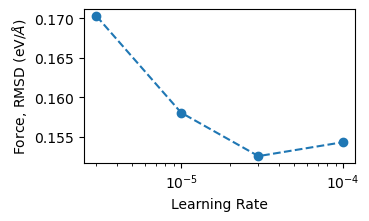

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.semilogx(cutoff_subset['learning_rate'], cutoff_subset['force_rmse'], '--o')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Force, RMSD (eV/$\\AA$)')

Check if we can do better with learning rate patience

In [9]:
subset = to_eval.query('num_epochs==16 and learning_rate==3e-5 and delta_force==10').sort_values('lr_patience')

Text(0, 0.5, 'Force, RMSD (eV/$\\AA$)')

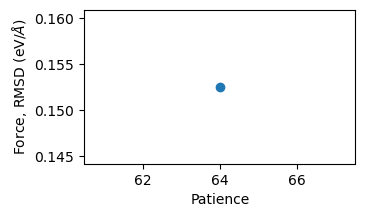

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(subset['lr_patience'], subset['force_rmse'], '--o')

ax.set_xlabel('Patience')
ax.set_ylabel('Force, RMSD (eV/$\\AA$)')

I don't trust the low patience (2) enough to ignore the trend of "more patience is better." I'm going to use a patience of 64 in the long-scale runs.

Check to make sure we don't overfit on the number of epochs

In [11]:
subset = to_eval.query('learning_rate==3e-5 and delta_force==10 and lr_patience==64').sort_values('num_epochs')

Text(0, 0.5, 'Force, RMSD (eV/$\\AA$)')

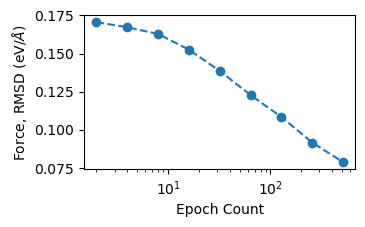

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.semilogx(subset['num_epochs'], subset['force_rmse'], '--o')

ax.set_xlabel('Epoch Count')
ax.set_ylabel('Force, RMSD (eV/$\\AA$)')

Text(0, 0.5, 'Test Loss')

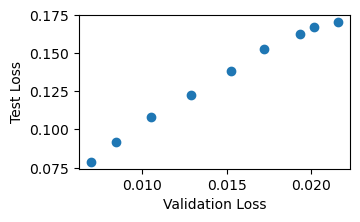

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(subset['valid_force_loss'], subset['force_rmse'], 'o')

ax.set_xlabel('Validation Loss')
ax.set_ylabel('Test Loss')

## Learning Curve
Figure out if we've completly converged wrt to number of epochs

In [14]:
best = to_eval.sort_values('force_rmse').iloc[0]
best

path                runs/md-100k/n512-lr3.0e-05-5c927961
starting_model                                   md-100k
huber_deltas                                 [0.1, 10.0]
num_epochs                                           512
batch_size                                            32
learning_rate                                    0.00003
lr_patience                                           64
energy_weight                                        0.1
max_force                                             10
test_runtime                                   11.944633
energy_mae                                      0.000473
force_rmse                                      0.078827
delta_energy                                         0.1
delta_force                                         10.0
valid_force_loss                                0.007004
Name: 40, dtype: object

In [15]:
log = pd.read_csv(best.path / 'train_log.csv')

Text(0, 0.5, 'Loss')

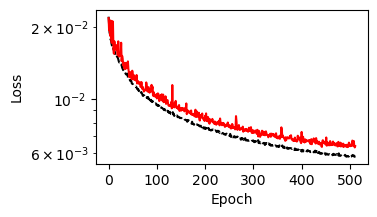

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.semilogy(log['epoch'], log['train_loss_total'], '--k')
ax.semilogy(log['epoch'], log['valid_loss_total'], '-r')


ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

We don't finish converging even past 32 epochs. Need to set up a longer run

## Plot the Learning Data
Get an idea of what level of errors to expect

In [17]:
test_data = pd.read_csv(best.path / 'test_records.csv.gz').sort_values('n_atoms')
print(f'Loaded {len(test_data)} test records')

Loaded 10076 test records


Show the predicted vs actual

In [18]:
true_forces = np.concatenate(test_data['force_true'].apply(json.loads).apply(np.ravel))

In [19]:
ml_forces = np.concatenate(test_data['force_ml'].apply(json.loads).apply(np.ravel))

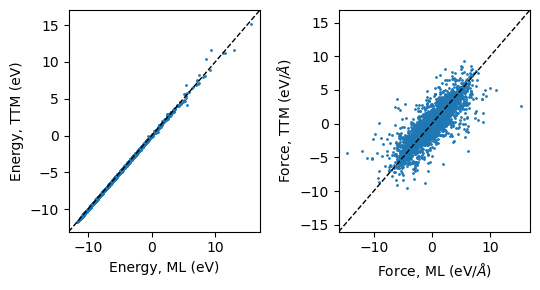

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 3.))

# Energy plot
axs[0].scatter(test_data['energy_ml'], test_data['energy_true'], s=1)
axs[0].set_xlabel('Energy, ML (eV)')
axs[0].set_ylabel('Energy, TTM (eV)')

# Force plot
m = axs[1].scatter(ml_forces, true_forces, s=1)
axs[1].set_xlabel('Force, ML (eV/$\\AA$)')
axs[1].set_ylabel('Force, TTM (eV/$\\AA$)')

for ax in axs:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

fig.tight_layout()

## Save path to best model
Do these for every pretraining we are working from

In [21]:
best_model_dir = Path('best-models/')
for name, group in summary.groupby('starting_model'):
    best_model = group.sort_values('force_rmse').iloc[0]
    print(f'Best model for {name} is {best_model["path"].name}')
    
    # Save a link
    best_path = best_model_dir / name
    if best_path.is_symlink():
        best_path.unlink()
    best_path.symlink_to('..' / best_model.path)

Best model for md-100k is n512-lr3.0e-05-5c927961
Best model for md-100k-large is n512-lr3.0e-05-5c927961
Best model for md-20k is n512-lr3.0e-05-5c927961
